In [6]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
processed_fif_file = 'subj04_session2_epo.fif'
processed_fif_path = os.path.join('..', 'eeg_data', 'final_eeg', '05_125', processed_fif_file)
epochs = mne.read_epochs(processed_fif_path)

Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3840 matching events found
No baseline correction applied
0 projection items activated


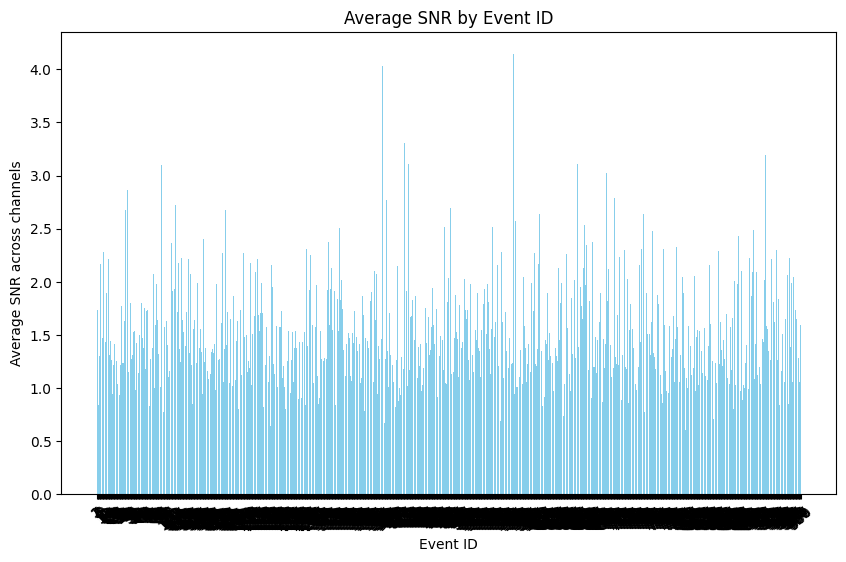

In [11]:
# Define the time window in seconds
tmin, tmax = 0.1, 0.3

# We will calculate SNR for each unique event in the epochs
event_ids = epochs.event_id
snr_results = {}

for event_id, _ in event_ids.items():
    # Select epochs for the current event_id
    epochs_specific = epochs[event_id]
    
    # Get data and times, restrict to the time window of interest
    data = epochs_specific.get_data(picks='eeg')  # shape: (n_epochs, n_channels, n_times)
    times = epochs_specific.times
    time_window_mask = (times >= tmin) & (times <= tmax)
    
    # Calculate mean amplitude in the specified time window for each epoch
    mean_amplitudes = data[:, :, time_window_mask].mean(axis=2)  # shape: (n_epochs, n_channels)
    
    # Calculate the average ERP waveform (signal) across epochs for the event_id
    signal = mean_amplitudes.mean(axis=0)
    
    # Calculate the standard deviation across epochs for each channel
    sd = np.std(mean_amplitudes, axis=0)
    
    # Calculate N (the number of epochs for the current event_id)
    N = len(epochs_specific)
    
    # Calculate the Simple Measurement Error (SME) for each channel
    SME = sd / np.sqrt(N)
    
    # Calculate SNR for each channel
    SNR = np.abs(signal) / SME
    
    # Store the results
    snr_results[event_id] = SNR

# Optionally, print the SME for each event_id (and each channel, if you wish)
# for event_id, SME in sme_results.items():
#     print(f"Event ID: {event_id}")
#     for i, sme_value in enumerate(SME):
#         print(f"  Channel {i+1}: SME = {sme_value}")

# Plotting SNR for a representative channel or average over channels, if preferred
# For simplicity, let's plot the average SNR across channels for each event ID
average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}
events = list(average_snr_per_event.keys())
average_snr_values = list(average_snr_per_event.values())

plt.figure(figsize=(10, 6))
plt.bar(events, average_snr_values, color='skyblue')
plt.xlabel('Event ID')
plt.ylabel('Average SNR across channels')
plt.title('Average SNR by Event ID')
plt.xticks(rotation=45)
plt.show()
